# North Atlantic SST Analysis with ERA5 ARCO

This notebook demonstrates how to compute and visualise **Sea Surface Temperature (SST)** over the North Atlantic region using the [Analysis‑Ready, Cloud‑Optimised ERA5 dataset (ARCO)](https://github.com/google-research/arco-era5). The data are hosted in a public Google Cloud Storage bucket and can be streamed lazily into memory using **xarray** and **dask**.

We will:

1. Load the ARCO ERA5 dataset (surface and pressure levels) from its Zarr store.
2. Subset the domain to the North Atlantic region (approx. 5–32°E, 55–72°N) and convert SST from Kelvin to Celsius.
3. Mask land grid cells and heavy sea‑ice by thresholding the sea‑ice area fraction.
4. Aggregate the SST to monthly means.
5. Extract the latest available monthly mean SST field.
6. Plot the results using **Matplotlib** and **Cartopy**.

> **Prerequisites**: You will need recent versions of `xarray`, `dask`, `gcsfs` and `numpy`. Install them with e.g.:
>
> ```bash
> pip install "xarray[complete]" dask[complete] gcsfs cartopy matplotlib numpy
> ```

ARCO ERA5 data are updated monthly; to make sure you access the latest available period, we read the dataset attributes `valid_time_start` and `valid_time_stop` exposed in the Zarr metadata. The dataset path used here streams the unified 0.25° pressure and surface levels dataset.


In [1]:
import numpy as np
import xarray as xr
import os
import dask
from dask.distributed import Client, LocalCluster

# Path to the ARCO ERA5 Analysis‑Ready 0.25° Zarr store
zarr_path = "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2"

cluster = LocalCluster(
    n_workers=max(1, os.cpu_count() - 1),
    threads_per_worker=1,           
    processes=True,
    memory_limit="auto"
)
client = Client(cluster)

# Make xarray use Dask by default
dask.config.set({"array.slicing.split_large_chunks": True})

ds = xr.open_zarr(
    zarr_path,
    chunks={},
    storage_options={"token": "anon"},
)

# Restrict to the valid time range indicated by dataset attributes
# This ensures we only access available data and avoid NaNs at the edges
valid_start = ds.attrs.get('valid_time_start')
valid_stop = ds.attrs.get('valid_time_stop')

lon_name = "longitude"
lat_name = "latitude"
spatial_dim = "values"  # default name for ARCO ERA5 zarr store

if valid_start and valid_stop:
    ds = ds.sel(time=slice(valid_start, valid_stop))
    print(f"Dataset spans {valid_start} to {valid_stop}")
else:
    print("valid_time_start/stop attributes missing; using full time range")
    
ds

/var/folders/kt/p8s_dv_d51j0lyctg8rbym5w0000gn/T/ipykernel_36549/3749538220.py:21: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_zarr(


Dataset spans 1940-01-01 to 2025-03-31


<xarray.Dataset> Size: 62TB
Dimensions:              (time: 747288, values: 542080)
Coordinates:
  * time                 (time) datetime64[ns] 6MB 1940-01-01 ... 2025-03-31T...
    depthBelowLandLayer  float64 8B ...
    entireAtmosphere     float64 8B ...
    latitude             (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 8B ...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
    valid_time           (time) datetime64[ns] 6MB dask.array<chunksize=(747288,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    d2m                  (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    hcc                  (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    istl1                (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    istl2                (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    istl3                (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    u10                  (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    u100                 (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    v10                  (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    v100                 (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
    z                    (time, values) float32 2TB dask.array<chunksize=(1, 542080), meta=np.ndarray>
Attributes: (12/14)
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2023-08-27T15:04 GRIB to CDM+CF via cfgrib-0.9...
    ...                        ...
    pangeo-forge:inputs_hash:  89c3caaaaf19eb0f6e9749dbde6c93972d64419137e2c8...
    pangeo-forge:recipe_hash:  09c22f5fffc2fbe3742fbb38c8c2c761e1b41b50570f09...
    pangeo-forge:version:      0.9.5.dev2+gd43015b
    valid_time_start:          1940-01-01
    valid_time_stop:           2025-03-31
    valid_time_stop_era5t:     2025-10-31

## Subsetting the North Atlantic and Masking Sea Ice

We define a bounding box covering Iceland, the Norwegian/Barents Sea and a slice of the Greenland Sea, then compute a mask to select grid cells whose latitudes and longitudes fall within this box. Since ERA5 stores longitudes from 0–360°, I normalise them to −180–180° before masking.

The SST variable is provided in Kelvin and includes values over both ocean and sea ice. To make a meaningful map of the ocean surface, we convert the temperatures to degrees Celsius and use the sea‑ice concentration (`siconc`) variable to mask out ice. Setting an ice threshold of 15% (ice fraction < 0.15) is a common convention; it removes the grid cells dominated by ice while retaining marginal ice zones. Because ARCO stores the data in chunks, we also re‑chunk the dataset to suit our compute environment. Finally, we compute a plotting extent with a bit of padding so that the map we generate later nicely frames the region.

It's worth noting that this geographic subsetting is a perfect example of what ARCO enables. Instead of downloading the entire global field, the `xarray`/`dask` combination fetches just the SST and sea‑ice chunks covering our polygon.

In [2]:
# Iceland + Norwegian/Barents, a touch of Greenland, farther north
TARGET_EXTENT = (-32.0, 42.0, 50.0, 84.0)  # (lon_min, lon_max, lat_min, lat_max)

if lon_name not in ds.coords or lat_name not in ds.coords:
    raise KeyError(f"Could not find lon/lat coords. Found coords: {list(ds.coords)}")

# Normalize once on the dataset coordinate (lazy; no load)
ds = ds.assign_coords({lon_name: ((ds[lon_name] + 180) % 360) - 180})

# Load coord arrays into NumPy to build a deterministic bbox index
lon_np = ds[lon_name].load().values
lat_np = ds[lat_name].load().values

# Build bbox mask from TARGET_EXTENT
lon_min, lon_max, lat_min, lat_max = TARGET_EXTENT
bbox_mask_np = (
    (lon_np >= lon_min) & (lon_np <= lon_max) &
    (lat_np >= lat_min) & (lat_np <= lat_max)
)
bbox_idx = np.where(bbox_mask_np)[0]
if bbox_idx.size == 0:
    raise ValueError(f"No points found inside bbox {TARGET_EXTENT}. "
                     "Check longitude normalization and bounds.")

# Subset main dataset by NUMERIC indices (keeps lon/lat/value alignment)
region_ds = ds.isel({spatial_dim: bbox_idx})

sst = region_ds["sst"]
ci = region_ds["siconc"]

# Convert to Celsius and mask sea-ice (>= 0.15)
sst_C = (sst - 273.15).astype('float32').rename("sst_C")
sst_C = sst_C.chunk({"time": 12, spatial_dim: "auto"})

ice_threshold = 0.15

if ci is not None:
    sst_C = sst_C.where(ci <= ice_threshold)

lon_arr = region_ds[lon_name].values
lat_arr = region_ds[lat_name].values

valid = np.isfinite(lon_arr) & np.isfinite(lat_arr)
if not np.any(valid):
    raise ValueError("No finite lon/lat points in region_ds to compute plot extent.")

xmin = float(np.nanmin(lon_arr[valid])); xmax = float(np.nanmax(lon_arr[valid]))
ymin = float(np.nanmin(lat_arr[valid])); ymax = float(np.nanmax(lat_arr[valid]))

# Padding in degrees (small but avoids tight clipping)
pad_x = max(0.75, 0.03 * (xmax - xmin))
pad_y = max(0.60, 0.03 * (ymax - ymin))

# Optional cap to avoid extreme Mercator stretch at very high latitudes
CAP_NORTH = 76.0  # set to None to disable

xmin = max(-180.0, xmin - pad_x)
xmax = min( 180.0, xmax + pad_x)
ymin = max( -90.0,  ymin - pad_y)
ymax = min((CAP_NORTH if CAP_NORTH is not None else 85.0), ymax + pad_y)

plot_extent = [xmin, xmax, ymin, ymax]

# Monthly mean SST
sst_monthly = sst_C.resample(time="1MS").mean()

sst_C

<xarray.DataArray 'sst_C' (time: 747288, values: 13011)> Size: 39GB
dask.array<where, shape=(747288, 13011), dtype=float32, chunksize=(1, 13011), chunktype=numpy.ndarray>
Coordinates:
  * time                 (time) datetime64[ns] 6MB 1940-01-01 ... 2025-03-31T...
    depthBelowLandLayer  float64 8B 100.0
    entireAtmosphere     float64 8B 0.0
    latitude             (values) float64 104kB 83.89 83.89 ... 50.16 50.16
    longitude            (values) float64 104kB 0.0 2.5 5.0 ... -0.8333 -0.4167
    number               int64 8B 0
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    valid_time           (time) datetime64[ns] 6MB 1940-01-01 ... 2025-03-31T...
Dimensions without coordinates: values

## Plotting the SST Map

Finally, we visualise the SST data using **Matplotlib** and **Cartopy**. The map includes a base layer from Stamen's terrain tiles, overlaid with our SST data. We use a diverging colormap to highlight anomalies, with a color bar indicating the temperature scale. The plot is configured to be landscape-oriented and larger for better visibility.

/Users/andrei/pineviewlabs/arco-ssts/venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 358.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/var/folders/kt/p8s_dv_d51j0lyctg8rbym5w0000gn/T/ipykernel_36549/874007961.py:96: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  Zi.mask = np.logical_or(Zi.mask, sv.contains(land_union, Xi, Yi))
/Users/andrei/pineviewlabs/arco-ssts/venv/lib/python3.12/site-packages/cartopy/io/img_tiles.py:414: UserWarning: The Stamen styles are no longer served by Stamen and are now served by Stadia Maps. Please use the StadiaMapsTiles cla

<urlopen error [Errno 8] nodename nor servname provided, or not known><urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlope

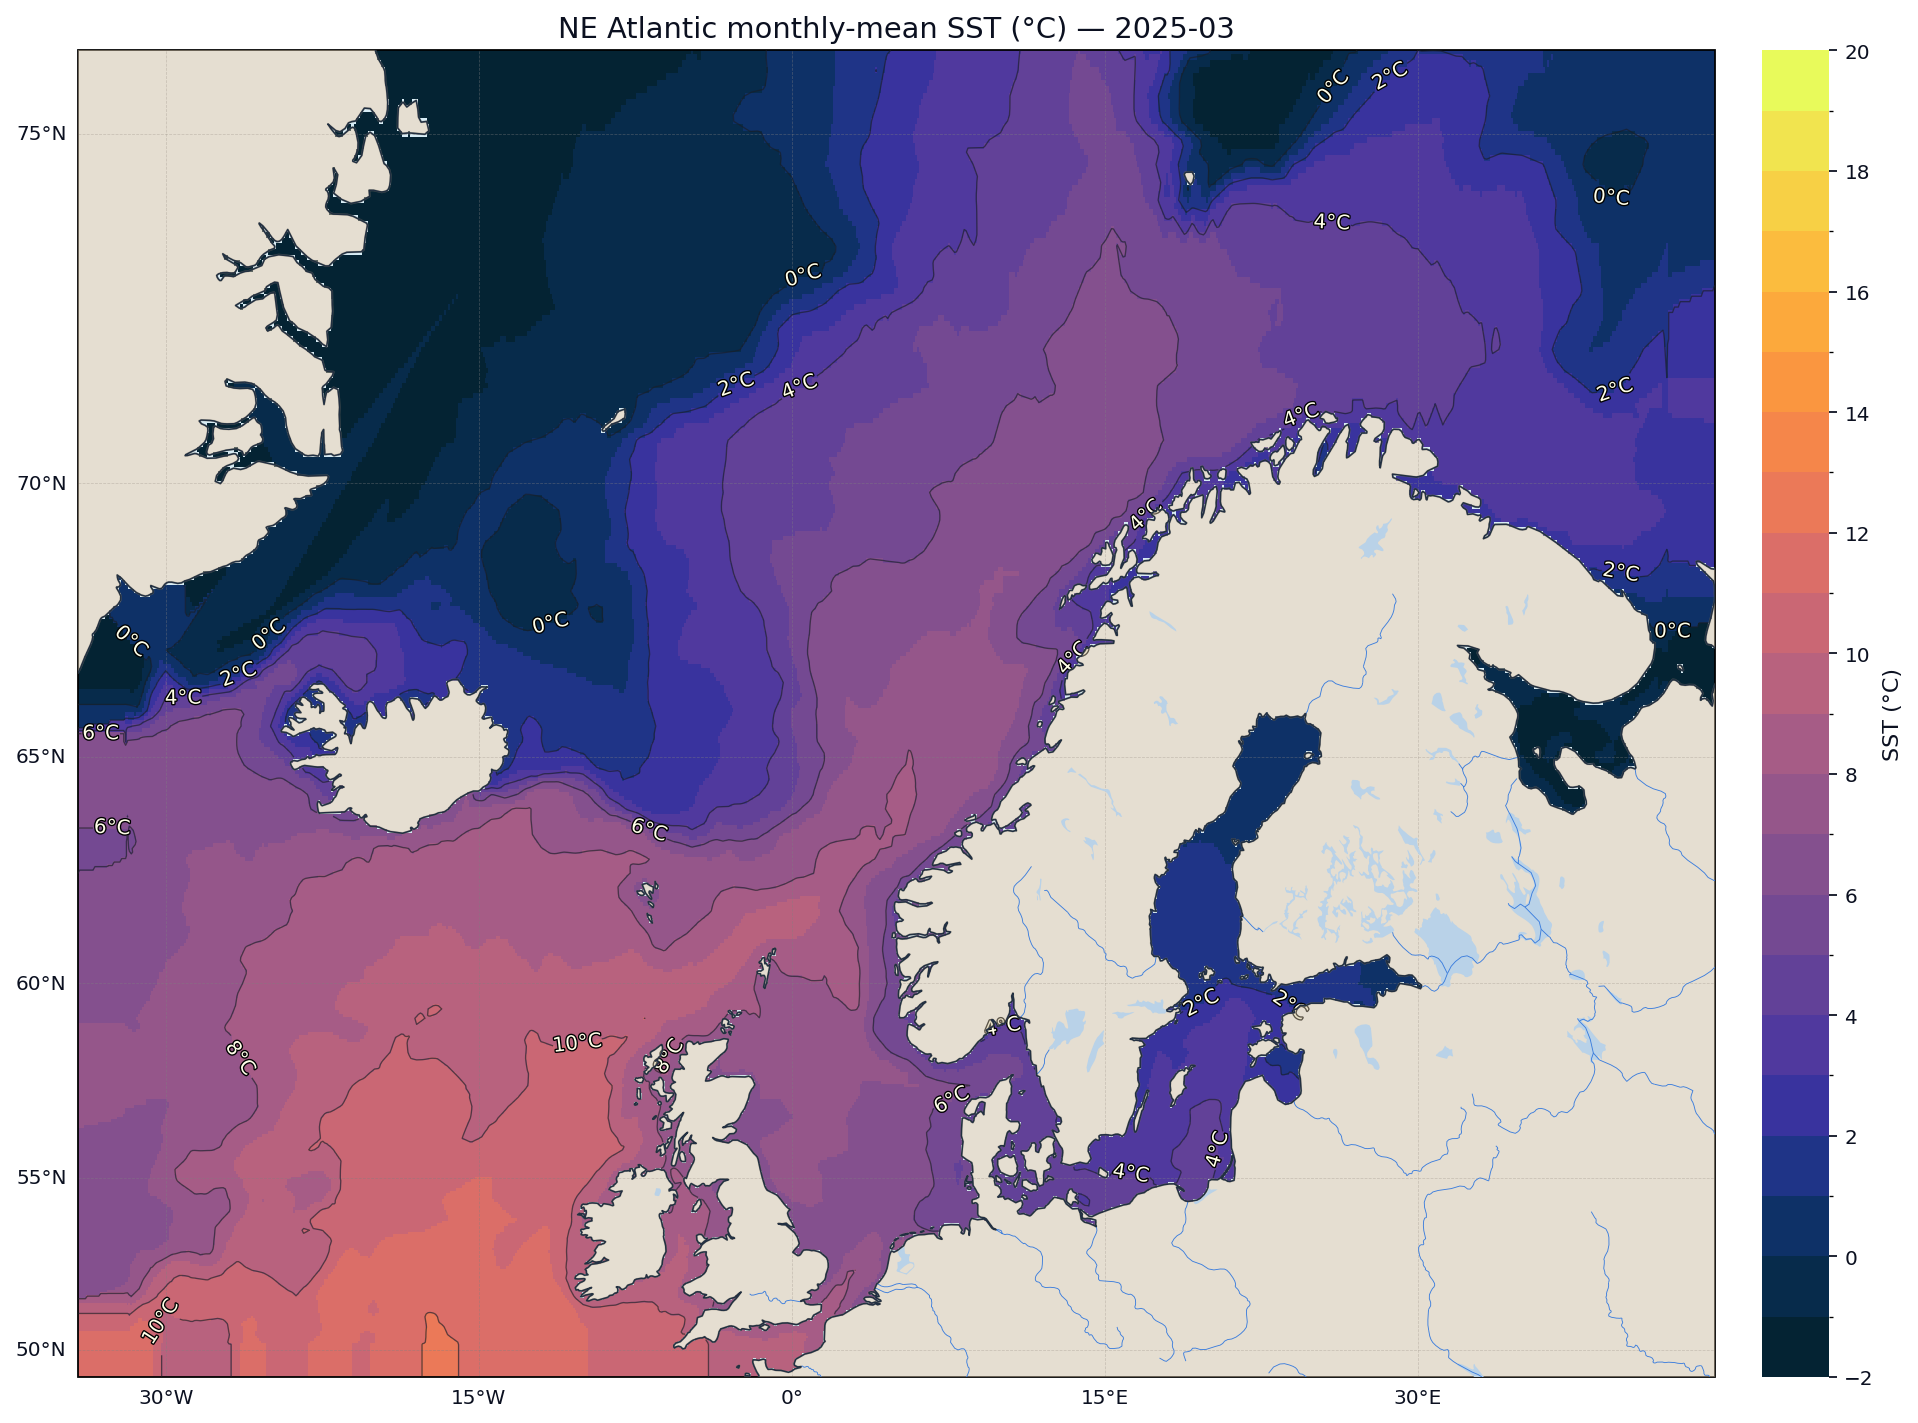

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patheffects as pe
from cartopy.io import img_tiles as cimgt
from cartopy.io import shapereader as shpreader
from shapely.ops import unary_union


# High-contrast discrete colormap (1°C steps)
boundaries = np.arange(-2, 21, 1)  # -2..20 °C
try:
    import cmocean
    cmap = cmocean.cm.thermal
except Exception:
    from matplotlib import cm
    cmap = cm.turbo
norm = mcolors.BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

# Prepare data for this frame
lon_name, lat_name = 'longitude', 'latitude'
latest_time = sst_monthly.time.max().values
vals = sst_monthly.sel(time=latest_time).load().values  # 1D

lon = region_ds[lon_name].values
lat = region_ds[lat_name].values

# Keep only finite points
valid = np.isfinite(vals) & np.isfinite(lon) & np.isfinite(lat)
lon_v, lat_v, z_v = lon[valid], lat[valid], vals[valid]
if lon_v.size < 3:
    raise ValueError("Not enough valid points to triangulate.")

# Normalize longitudes (safety)
if np.nanmax(lon_v) > 180:
    lon_v = ((lon_v + 180) % 360) - 180

# Triangulation (mild quality filter)
tri = mtri.Triangulation(lon_v, lat_v)
try:
    tri.set_mask(mtri.TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio=0.0005))
except Exception:
    pass

# Grid over the selection-driven extent
xmin, xmax, ymin, ymax = plot_extent
deg_w, deg_h = (xmax - xmin), (ymax - ymin)

# Cap total grid cells for speed while preserving aspect
max_cells = 250_000
aspect = max(deg_w / max(deg_h, 1e-6), 1e-6)
ny = int(np.sqrt(max_cells / aspect))
nx = int(max_cells // max(ny, 1))
nx = int(np.clip(nx, 500, 1400))
ny = int(np.clip(ny, 350, 900))

xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
Xi, Yi = np.meshgrid(xi, yi)

# Linear interpolation on the triangulation (inside the hull)
Zi = mtri.LinearTriInterpolator(tri, z_v)(Xi, Yi)
Zi = np.asarray(Zi)  # may be masked array -> ndarray with NaNs

# Robust nearest-neighbor backfill to cover full bbox
try:
    from scipy.spatial import cKDTree
    nan_mask = np.isnan(Zi)
    if nan_mask.any():
        mean_lat = float(np.nanmean(lat_v))
        cos_phi = np.cos(np.deg2rad(mean_lat))
        tree = cKDTree(np.c_[lon_v * cos_phi, lat_v])
        _, idx = tree.query(np.c_[Xi[nan_mask] * cos_phi, Yi[nan_mask]], k=1)
        Zi[nan_mask] = z_v[idx]
except Exception:
    pass

Zi = np.ma.masked_invalid(Zi)

# Mask SST over land (simple & fast)
land_shp = shpreader.natural_earth(resolution='50m', category='physical', name='land')
land_union = unary_union(list(shpreader.Reader(land_shp).geometries()))
try:
    land_union = land_union.buffer(0.01)  # tiny buffer to avoid coastal bleed
except Exception:
    pass

try:
    from shapely import vectorized as sv
except Exception:
    import shapely.vectorized as sv
Zi.mask = np.logical_or(Zi.mask, sv.contains(land_union, Xi, Yi))

# Projections
proj_data = ccrs.PlateCarree()
tiles = cimgt.Stamen('terrain-background')
proj_map = tiles.crs  # Web Mercator

# Plot
plt.rcParams['figure.dpi'] = 160
fig, ax = plt.subplots(
    figsize=(16, 9),            
    subplot_kw={'projection': proj_map}
)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj_data)
ax.set_aspect('auto')

# Base tiles and a light ocean fill
ax.add_image(tiles, 5, zorder=0, alpha=1.0)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#d7ecf6', edgecolor='none', zorder=1)

# SST field
pcm = ax.pcolormesh(
    Xi, Yi, Zi, cmap=cmap, norm=norm, shading='auto',
    transform=proj_data, zorder=2
)

# Isotherms — clearer but subtle
cs = ax.contour(
    Xi, Yi, Zi, levels=np.arange(-2, 21, 2), colors='#1a1e27',
    linewidths=0.6, alpha=0.65, transform=proj_data, zorder=3
)
lbls = ax.clabel(cs, fmt='%d°C', fontsize=9, inline=True)
for t in lbls:
    t.set_color('#ffffe8')
    t.set_path_effects([pe.withStroke(linewidth=1.2, foreground='black')])

# Minimal, readable reference layers
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#cdbda1', edgecolor='#8a7f6b', alpha=0.45, zorder=5)
ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='#b9d2e8', edgecolor='none', zorder=6)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='#3b7ddd', linewidth=0.4, zorder=7)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.7, color='#223042', zorder=9)

# Gridlines with clearer labels
gl = ax.gridlines(draw_labels=True, linewidth=0.35, color='gray', alpha=0.45, linestyle='--')
gl.right_labels = gl.top_labels = False
gl.xlocator = mticker.MaxNLocator(6)
gl.ylocator = mticker.MaxNLocator(6)
gl.xlabel_style = {
    'size': 9, 'color': '#0b1020',
    'bbox': dict(facecolor='white', edgecolor='none', alpha=0.75, boxstyle='round,pad=0.15')
}
gl.ylabel_style = gl.xlabel_style

# Colorbar + title
cb = plt.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.035, pad=0.02, ticks=boundaries[::2])
cb.set_label('SST (°C)', fontsize=10, color='#0b1020')
cb.ax.tick_params(labelsize=9, colors='#0b1020')
cb.outline.set_visible(False)

date_str = np.datetime_as_string(latest_time, "M")
ax.set_title(f"NE Atlantic monthly-mean SST (°C) — {date_str}", fontsize=13, color="#0b1020")

plt.tight_layout()
plt.show()
